<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подклбючаем необходимые библиотеки и создаем переменные.

In [55]:
import pandas as pd
import numpy as np
import re
import spacy
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score as f1
from sklearn.ensemble import RandomForestClassifier as RFC

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from nltk.corpus import stopwords as nltk_stopwords


RANDOM_STATE = 7894651

In [3]:
df = pd.read_csv('./toxic_comments.csv')

In [4]:
def get_info(df):
    display(df.info())
    display(df.sample(5))

In [5]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
127951,128083,Wikipedia:WikiProject Munich\nWould you like t...,0
118808,118908,"""UNLESS YOU""""RE JIMBO WALES INFORMING ME OF MY...",0
101557,101654,THIS GUY NEEDS HELP'''''',0
95632,95724,AfC archiving \n\nHello. You asked,0
147914,148070,"""\n\n Bar Association of San Francisco \n\nHi...",0


В данных есть столюец "Unnamed: 0" возможно это бывшая индексация.

In [6]:
len(df['Unnamed: 0'].unique())

159292

Количество уникальных значений совпадает с количеством строк в таблице, предположение верно, нам этот столбец не нужен удалим его.

In [7]:
df = df.loc[:,['text','toxic']]

In [8]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
65243,"""\n\n Knight undoing \n\n""""This is simply mean...",0
139568,"""\n\n A barnstar for you! \n\n The Admin's Ba...",0
87382,Brisbane meetup invitation\n\nHi there! You a...,0
25635,"""\nWow, thanks for the barnstar! My second one...",0
81764,Regarding edits made during February 6 2007 (U...,0


Теперь можно заняться непосредственно коментариями

## Работа с комментариями

На первый взгляд в комментариях нету лишних символов за исключением символа новой строки "\n"

По этому заменим их на пробелы

In [9]:
def clear_re (df):
    df['text'] = re.sub(r'\n',' ',df['text'])
    return df

In [10]:
df = df.apply(clear_re,axis=1)

In [11]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
64138,I've corrected the nesting. McGovern did run i...,0
36053,""" This guy is guilty of paying $160k for wor...",0
132323,""" Direction The signs may be east–west, bu...",0
39754,""" Welcome Hello and welcome to Wikipedia! W...",0
93996,x factor Excuse me but why are you removing ...,0


Теперь можно убрать знаки припинания и привести слова в начальную форму.

In [12]:
nlp = spacy.load("en_core_web_sm")
def lemmatize(df):
    text = ''
    doc = nlp(df['text'])
    for token in doc:
        if token.is_stop: continue
        text += f'{token.lemma_} '
    df['text'] = text
    return df

In [ ]:
df = df.apply(lemmatize, axis=1)

In [14]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
57800,Edit request 18 February 2013 add Perovo So...,0
129050,not u speak like d advise u watch ur mouth ! !,1
6577,"welcome ! hello , Ammypanwar , welcome Wikip...",0
76987,""" category deletion visit weigh ! ( T ...",0
39728,certain intend comment . — Carl ( · talk ),0


In [15]:
def punctuation(df):
    df['text'] = re.sub(r'[.,()!?:;\-\'\"=\[\]&/\\]','',df['text'])
    df['text'] = re.sub(r'\s',' ',df['text'])
    df['text'] = df['text'].lower()
    return df

In [16]:
df = df.apply(punctuation,axis=1)

In [17]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
128787,thank edit rescue article maintenance tracki...,0
43058,thing son biche fuck youfuck block properl...,1
112762,confused comment straw poll decision b...,0
42662,administer allegedly spamme completely...,0
85979,try britannicacom best source info dont was...,0


Данные подготовлены, теперь осталось только посмотреть на распределение целевого признака.

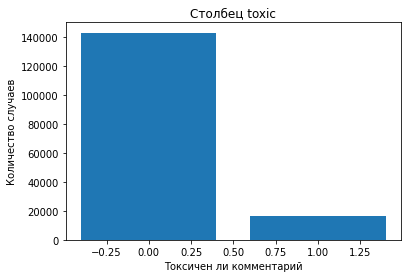

In [57]:
toxic = df['toxic'].value_counts()

plt.xlabel("Токсичен ли комментарий")
plt.ylabel("Количество случаев")
plt.title("Столбец toxic")
plt.bar(toxic.index,toxic.values)
plt.show()

Видно, что тут явный дисбаланс, юудем учитывать это при обучении.

### Обучение

Сначала нужно разбить данные на выборки.

In [22]:
train,test = train_test_split(df, random_state=RANDOM_STATE, test_size=.25)

In [23]:
get_info(test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39823 entries, 119984 to 146791
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39823 non-null  object
 1   toxic   39823 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 933.4+ KB


None

,text,toxic
157234,hey person suffer read bullshit wiki...,1
90410,eugene delmar edit say win match delm...,0
124825,life scholar person edit discus guy sitush s...,0
81677,hazel eye myth description hazel eye say gre...,0
87019,possibly unfree image kahuluiairportmapjpg ...,0


In [24]:
get_info(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119469 entries, 16933 to 122325
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    119469 non-null  object
 1   toxic   119469 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


None

,text,toxic
104498,definitely improve democrat page informat...,0
52754,point citation people read revert edit oh bo...,1
26104,thank hope feel well peace,0
107442,ginge offender hi add template article...,0
3780,yes sir revert change highlighted chang...,0


Теперь нужен TF-IDF

In [25]:
corpus = train['text'].values.astype('U')

stopwords = list(nltk_stopwords.words('english'))

In [26]:
tf_idf = TfidfVectorizer(stop_words=stopwords).fit(corpus)

In [59]:
train_tf = tf_idf.transform(corpus)
corpus = test['text'].values.astype('U')
test_tf = tf_idf.transform(corpus)

#### LogisticRegression

In [33]:
warnings.filterwarnings("ignore")
parametrs = {"solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "max_iter": range(1000,2000,100),
             "penalty": ['l1', 'l2', 'elasticnet', 'none']}
model_LR = GridSearchCV(lr(random_state=46812), 
                        parametrs,
                        scoring = 'f1',
                        verbose = 3,
                        cv=2)
model_LR.fit(train_tf, train['toxic'])
model_LR.best_params_

Fitting 2 folds for each of 200 candidates, totalling 400 fits
[CV 1/2] END max_iter=1000, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/2] END max_iter=1000, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/2] END max_iter=1000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/2] END max_iter=1000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/2] END max_iter=1000, penalty=l1, solver=liblinear;, score=0.750 total time=   0.4s
[CV 2/2] END max_iter=1000, penalty=l1, solver=liblinear;, score=0.749 total time=   0.4s
[CV 1/2] END max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/2] END max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/2] END max_iter=1000, penalty=l1, solver=saga;, score=0.750 total time=  12.3s
[CV 2/2] END max_iter=1000, penalty=l1, solver=saga;, score=0.749 total time=  11.3s
[CV 1/2] END max_iter=1000, penalty=l2, solver=newton-cg;, score=0.679 total ti

{'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

In [54]:
model_LR.best_score_

0.7492733100385021

Прекрасно, уже есть модель которая преодалела необходимый порог.

#### CatBoostClassifier

In [52]:
parametrs = {'depth' :range(2,9,3),
            'iterations' : range(1100,1501,250),
            'learning_rate' : [.7,.5,.3],
            'l2_leaf_reg':range(2,9,3)}
cbc = GridSearchCV(CatBoostClassifier(random_seed= RANDOM_STATE,
                        logging_level='Silent',
                        auto_class_weights='Balanced'), 
                    parametrs, 
                    scoring = 'f1',
                    verbose = 3,
                    cv=2)
cbc.fit(train_tf, train['toxic'])
print (cbc.best_params_)
print (cbc.best_score_)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.7;, score=0.748 total time= 2.3min
[CV 2/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.7;, score=0.748 total time= 2.3min
[CV 1/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.5;, score=0.754 total time= 2.3min
[CV 2/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.5;, score=0.755 total time= 2.3min
[CV 1/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.3;, score=0.751 total time= 2.3min
[CV 2/2] END depth=2, iterations=1100, l2_leaf_reg=2, learning_rate=0.3;, score=0.756 total time= 2.3min
[CV 1/2] END depth=2, iterations=1100, l2_leaf_reg=5, learning_rate=0.7;, score=0.747 total time= 2.3min
[CV 2/2] END depth=2, iterations=1100, l2_leaf_reg=5, learning_rate=0.7;, score=0.750 total time= 2.3min
[CV 1/2] END depth=2, iterations=1100, l2_leaf_reg=5, learning_rate=0.5;, score=0.752 total time= 

Как видно, CatBoostClassifier справился лучше, по этому на тестовой выборке будем использовать его.

## Тестовая выборка

In [60]:
f1(test['toxic'], cbc.predict(test_tf))

0.7807814897886908

Прекрасный результат.

## Выводы

Произвели поготовку текста для предсказания токсичности модели, обучили катбуст и получили итоговую метрику f1 0.78. Что является не плохим результатом.